In [1]:
# 导入标准库、第三方库和PyTorch模块
import os
import torch
import torchvision.transforms as transforms
import numpy as np
import logging
import json
from datetime import datetime

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

# 数据处理：数据集加载、缩放、归一化、格式转换、洗牌、批标准化。
def create_dataset(data_dir, training=True, batch_size=32, resize=(32, 32), rescale=1/(255*0.3081), shift=-0.1307/0.3081, buffer_size=64):
    transform = transforms.Compose([
        transforms.Resize(resize),
        transforms.ToTensor(),
        transforms.Normalize(mean=[shift], std=[rescale])
    ])

    ds = MNIST(root=data_dir, train=training, transform=transform, download=True)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=training, num_workers=4, pin_memory=True, drop_last=True)
    
    return loader


In [2]:
import torch.nn as nn

class LeNet5(nn.Module):
    """模型定义：算子初始化（参数设置），网络构建。"""
    def __init__(self, activation='relu', dropout_rate=None):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, 5, stride=1, padding=0)
        self.activation = activation
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(p=dropout_rate) if dropout_rate else None
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        act = self.relu if self.activation == 'relu' else self.sigmoid
        x = act(self.conv1(x))
        x = self.pool(x)
        x = act(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        if self.dropout:
            x = self.dropout(x)
        x = self.fc2(x)
        if self.dropout:
            x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    torch.cuda.set_device(device)  # 设置使用的 GPU
    torch.backends.cudnn.benchmark = True  # 自动寻找最快的卷积算法
    num_GPUs = torch.cuda.device_count()
    torch.cuda.set_device(0)  #选择GPU 0
    num_CPUs = 8  # 设置要使用的CPU核心数
    torch.set_num_threads(num_CPUs)  # 设置PyTorch线程数

In [4]:
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

def train(data_dir, loss_type='ce', activation='relu', dropout_rate=None, lr=0.01, momentum=0.9, num_epochs=10):
    ds_train = create_dataset(data_dir, training=True)
    ds_eval = create_dataset(data_dir, training=False)

    net = LeNet5(activation=activation, dropout_rate=dropout_rate)

    net.to(device)  # Move the model to the selected device

    if loss_type == 'mse':
        loss = nn.MSELoss()
    elif loss_type == 'ce':
        loss = nn.CrossEntropyLoss()
    else:
        raise ValueError("Invalid loss_type. Choose either 'mse' or 'ce'")

    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, data in enumerate(ds_train, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move the inputs and labels to the selected device
            opt.zero_grad()

            outputs = net(inputs)
            if loss_type == 'mse':
                labels = labels.long()
                labels_one_hot = torch.zeros(labels.shape[0], 10).to(device)
                labels_one_hot.scatter_(1, labels.view(-1, 1), 1)
                loss_output = loss(outputs, labels_one_hot)
            else:
                loss_output = loss(outputs, labels)

            loss_output.backward()
            opt.step()

            running_loss += loss_output.item()
        train_losses.append(running_loss)

        logging.info(f'Epoch {epoch + 1}, Loss: {running_loss}')

        correct = 0
        total = 0
        with torch.no_grad():
            for data in ds_eval:
                images, labels = data
                images, labels = images.to(device), labels.to(device)  # Move the images and labels to the selected device
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        acc = 100 * correct / total
        val_accuracies.append(acc)
        logging.info(f'Accuracy: {acc} %')

    return train_losses, val_accuracies


In [5]:
def plot_history(train_losses, val_acc, title):
    epochs = range(1, len(train_losses) + 1)

    plt.figure()
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure()
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [6]:
def setup_logger():
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    log_filename = f"training_logs_{timestamp}.log"
    
    logging.basicConfig(filename=log_filename,
                        filemode='w',
                        level=logging.INFO,
                        format='%(asctime)s [%(levelname)s] - %(message)s',
                        datefmt='%Y-%m-%d %H:%M:%S')
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s [%(levelname)s] - %(message)s')
    console.setFormatter(formatter)
    logging.getLogger('').addHandler(console)


2023-04-28 16:17:47,929 [INFO] - Training num_epochs=20,lr=0.0015,moentum=0.9

2023-04-28 16:17:47,929 [INFO] - 

 Training with ReLU Mean Squared Error without Dropout:


100.0%


Extracting MNIST_Data\MNIST\raw\train-images-idx3-ubyte.gz to MNIST_Data\MNIST\raw



100.0%


Extracting MNIST_Data\MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_Data\MNIST\raw



100.0%


Extracting MNIST_Data\MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_Data\MNIST\raw



100.0%


Extracting MNIST_Data\MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_Data\MNIST\raw



C:\Users\86177\AppData\Local\Temp\ipykernel_19916\1357045474.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
2023-04-28 16:18:10,324 [INFO] - Epoch 1, Loss: 45.85078444087412
2023-04-28 16:18:13,181 [INFO] - Accuracy: 94.07051282051282 %
2023-04-28 16:18:24,271 [INFO] - Epoch 2, Loss: 16.24986077909125
2023-04-28 16:18:27,261 [INFO] - Accuracy: 95.51282051282051 %
2023-04-28 16:18:39,201 [INFO] - Epoch 3, Loss: 12.21816091205983
2023-04-28 16:18:41,982 [INFO] - Accuracy: 96.47435897435898 %
2023-04-28 16:18:53,162 [INFO] - Epoch 4, Loss: 10.146193732139182
2023-04-28 16:18:56,043 [INFO] - Accuracy: 97.25560897435898 %
2023-04-28 16:19:07,247 [INFO] - Epoch 5, Loss: 8.867649031807105
2023-04-28 16:19:10,122 [INFO] - Accuracy: 97.70633012820512 %
2023-04-28 16:19:21,434 [INFO] - Epoch 6, Loss: 7.925211424177633
2023-04-28 16:19:24,421 [INFO] - Accuracy: 97.7363782051282 %
2023-04-28 16:1

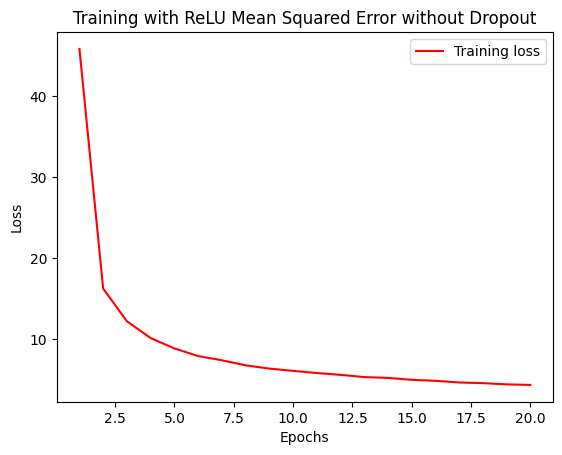

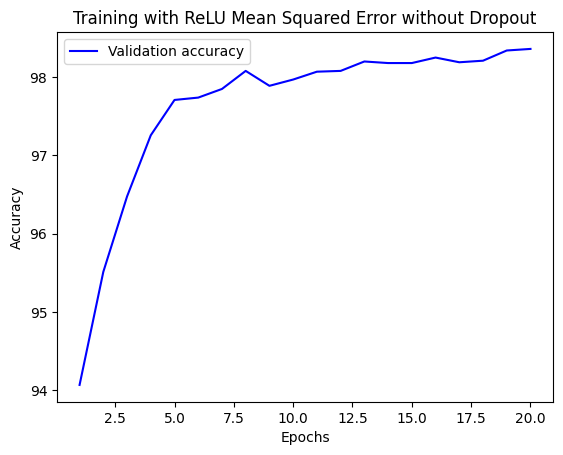

In [7]:
setup_logger()

data_dir = 'MNIST_Data'
num_epochs = 20
lr = 0.0015
momentum = 0.9
dropout_rate = 0.1

# Save hyperparameters
hyperparameters = {
    'num_epochs': num_epochs,
    'learning_rate': lr,
    'momentum': momentum
}
with open('hyperparameters.json', 'w') as f:
    json.dump(hyperparameters, f, indent=4)
logging.info(f"Training num_epochs={num_epochs},lr={lr},moentum={momentum}\n")
logging.info("\n\n Training with ReLU Mean Squared Error without Dropout:")
train_losses, val_acc = train(data_dir, activation='relu', loss_type='mse', dropout_rate=None, num_epochs=num_epochs, lr=lr, momentum=momentum)
plot_history(train_losses, val_acc, 'Training with ReLU Mean Squared Error without Dropout')


In [8]:
logging.info("\n\n Training with ReLU Cross Entropy without Dropout:")
train_losses, val_acc = train(data_dir, activation='relu', loss_type='ce',dropout_rate=None, num_epochs=num_epochs, lr=lr, momentum=momentum)
plot_history(train_losses, val_acc, 'Training with ReLU Cross Entropy without Dropout')


2023-04-28 16:22:52,986 [INFO] - 

 Training with ReLU Cross Entropy without Dropout:
C:\Users\86177\AppData\Local\Temp\ipykernel_19916\1357045474.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)
2023-04-28 16:23:04,679 [INFO] - Epoch 1, Loss: 3113.0171930789948
2023-04-28 16:23:07,525 [INFO] - Accuracy: 87.1895032051282 %
2023-04-28 16:23:18,247 [INFO] - Epoch 2, Loss: 2981.8682392835617
2023-04-28 16:23:21,725 [INFO] - Accuracy: 87.91065705128206 %
2023-04-28 16:23:33,816 [INFO] - Epoch 3, Loss: 2971.2128694057465
2023-04-28 16:23:37,022 [INFO] - Accuracy: 88.41145833333333 %
2023-04-28 16:23:48,486 [INFO] - Epoch 4, Loss: 2963.157282233238
2023-04-28 16:23:51,412 [INFO] - Accuracy: 88.87219551282051 %
2023-04-28 16:24:05,908 [INFO] - Epoch 5, Loss: 2957.9102642536163
2023-04-28 16:24:10,587 [INFO] - Accuracy: 88.38141025641026 %
2023-04-28 16:24:29,707 [INFO] - Epoch 6, Loss: 2955.70

KeyboardInterrupt: 

In [ ]:
logging.info("\n\n Training with Sigmoid Mean Squared Error without Dropout:")
train_losses, val_acc = train(data_dir, activation='sigmoid', loss_type='mse',dropout_rate=None, num_epochs=num_epochs+30, lr=lr+0.00075, momentum=momentum)
plot_history(train_losses, val_acc, 'Training with Sigmoid Mean Squared Error without Dropout')


In [ ]:
logging.info("\n\n Training with Sigmoid Cross Entropy without Dropout:")
train_losses, val_acc = train(data_dir, activation='sigmoid', loss_type='ce',dropout_rate=None, num_epochs=num_epochs, lr=lr, momentum=momentum)
plot_history(train_losses, val_acc, 'Training with Sigmoid Cross Entropy without Dropout')


In [ ]:
logging.info("\n\n Training with ReLU Mean Squared Error with Dropout:")
train_losses, val_acc = train(data_dir, activation='relu', loss_type='mse', dropout_rate=dropout_rate, num_epochs=num_epochs, lr=lr+0.0005, momentum=momentum)
plot_history(train_losses, val_acc, 'Training with ReLU Mean Squared Error with Dropout')


In [ ]:
logging.info("\n\n Training with ReLU Cross Entropy with Dropout:")
train_losses, val_acc = train(data_dir, activation='relu', loss_type='ce',dropout_rate=dropout_rate, num_epochs=num_epochs, lr=lr-0.0007, momentum=momentum)
plot_history(train_losses, val_acc, 'Training with ReLU Cross Entropy with Dropout')


In [ ]:
logging.info("\n\n Training with Sigmoid Mean Squared Error with Dropout:")
train_losses, val_acc = train(data_dir, activation='sigmoid', loss_type='mse',dropout_rate=dropout_rate, num_epochs=num_epochs, lr=lr, momentum=momentum)
plot_history(train_losses, val_acc, 'Training with Sigmoid Mean Squared Error with Dropout')


In [ ]:
logging.info("\n\n Training with Sigmoid Cross Entropy with Dropout:")
train_losses, val_acc = train(data_dir, activation='sigmoid', loss_type='ce',dropout_rate=dropout_rate, num_epochs=num_epochs, lr=lr, momentum=momentum)
plot_history(train_losses, val_acc, 'Training with Sigmoid Cross Entropy with Dropout')
